In [12]:
%load_ext autoreload
%autoreload 2

import os
import subprocess
import sys
import warnings

warnings.simplefilter("ignore", FutureWarning)

%aimport cnv_inference_config
project_config = cnv_inference_config
os.chdir(project_config.MB_ROOT)

from collections import Counter, defaultdict, OrderedDict
import itertools
from itertools import product as cartesian
import multiprocessing as mp
import pickle

from joblib import Parallel, delayed
import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats as sps
from tqdm import tqdm, tqdm_notebook

import matplotlib.pyplot as plt
import seaborn as sns

import toolkit
import util
from workspace.workspace_manager import WorkspaceManager

sns.set()

workspace = {}
for data_type in ["scDNA", "scRNA"]:
    workspace.update({ 
        data_type : WorkspaceManager(
            task_name="ase_to_cnv",
            experiment_info={"data" : data_type},
            verbose=True
        )
    })
    workspace[data_type].load_workspace()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
data = {}
for data_type in ["scDNA", "scRNA"]:
    data[data_type] = {
        data_name :
        util.pickle_load(data_dump)
        for data_name, data_dump in tqdm_notebook(
            workspace[data_type].tmp_data.items(),
            f"{data_type}, loading datasets into RAM"
        )
    }
    
for modality in ["scDNA", "scRNA"]:
    data[modality]["block_counts"].rename(
        columns={"GENE_ID" : "BLOCK_ID"}, 
        inplace=True
    )

In [14]:
common_blocks = (set(data["scDNA"]["block_counts"].BLOCK_ID) 
                & set(data["scRNA"]["block_counts"].BLOCK_ID))

print("Datasets have {} blocks in common".format(len(common_blocks)))

for modality in workspace.keys():
    data[modality]["block_counts"] = util.filter_by_isin(
        data[modality]["block_counts"], 
        "BLOCK_ID", 
        common_blocks
    ).reset_index(drop=True)

common_block_ids = data["scDNA"]["block_counts"]["BLOCK_ID"].values.astype(int)
    
assert (data["scDNA"]["block_counts"].shape[0] 
        == data["scRNA"]["block_counts"].shape[0])

Datasets have 8776 blocks in common


In [15]:
M_prime = toolkit.extract_barcodes(data["scDNA"]["block_counts"]).size
M = data["scRNA"]["clustering"]["LABEL"].unique().size 
# M = toolkit.extract_barcodes(data["scRNA"]["block_counts"]).size
K = data["scDNA"]["clustering"]["LABEL"].unique().size
N_G = data["scDNA"]["block_counts"].shape[0]
T_max = 5
tau = np.concatenate([[(t - k, k) for k in range(t + 1)] 
                      for t in range(1, T_max +1)])
conf_to_num = {tuple(cnv_config) : i for i, cnv_config in enumerate(tau)}
num_to_conf = {val : key for key, val in conf_to_num.items()}

In [16]:
D_G_prime = toolkit.extract_counts(data["scDNA"]["block_counts"]).values
D_G = toolkit.extract_counts(
    toolkit.aggregate_by_barcode_groups(
        data["scRNA"]["block_counts"],
        data["scRNA"]["clustering"]
    )
).values

A_G_prime = toolkit.extract_counts(
    data["scDNA"]["block_counts"], 
    suffix="ad"
).values
A_G = toolkit.extract_counts(
    toolkit.aggregate_by_barcode_groups(
        data["scRNA"]["block_counts"], 
        data["scRNA"]["clustering"]
    ),
    suffix="ad"
).values

In [17]:
f = data["scDNA"]["clustering"]["LABEL"].value_counts().sort_index().values / M_prime
assert np.isclose(f.sum(), 1)

In [18]:
rodata_dir = "/icgc/dkfzlsdf/analysis/B260/users/v390v/cnv_inference/data/raw/first_sample"
cnv = []
for i in tqdm_notebook(range(9), "reading CNV information"):
    snp_cnv = pd.read_csv(
        f"{rodata_dir}/TabHaplotypeblock_with_phasedSNPs_{i + 1}.bed", 
        usecols=[0, 1, 2, 3],
        names=["CHROM", "START", "END", "CNV"],
        sep='\t'
    )
    snp_cnv.drop_duplicates(inplace=True)
    print(snp_cnv.shape, np.median(snp_cnv["CNV"]))
    cnv.append(snp_cnv["CNV"].values.astype(int))
cnv = np.column_stack(cnv)
cnv[cnv > T_max] = T_max # CNV number clipping

(18011, 4) 2.0
(18011, 4) 2.0
(18011, 4) 2.0
(18011, 4) 2.0
(18011, 4) 4.0
(18011, 4) 2.0
(18011, 4) 2.0
(18011, 4) 2.0
(18011, 4) 2.0


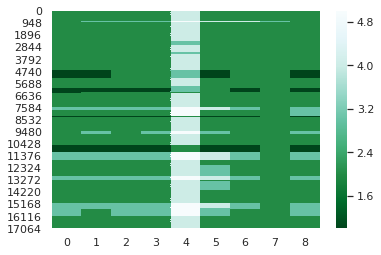

In [19]:
sns.heatmap(cnv, cmap="BuGn_r")

In [20]:
data["scDNA"]["clustering"]["LABEL"].value_counts()

2    47
1    45
4    33
5    31
7    25
3    25
6    24
8    22
9    16
Name: LABEL, dtype: int64

In [21]:
data["scDNA"]["clonal_block_counts"] = toolkit.aggregate_by_barcode_groups(
    data["scDNA"]["block_counts"],
    data["scDNA"]["clustering"]
)

D_C_prime = toolkit.extract_counts(
    data["scDNA"]["clonal_block_counts"]
).values
A_C_prime = toolkit.extract_counts(
    data["scDNA"]["clonal_block_counts"], "ad"
).values

In [22]:
def beta_mode(a, b):
    return (a - 1) / (a + b - 2)

In [23]:
T = np.full_like(D_C_prime, np.nan)
for block_id, clone_id in tqdm_notebook(cartesian(range(N_G), range(K))):
    t = cnv[block_id, clone_id]
    ad = A_C_prime[block_id, clone_id]
    dp = D_C_prime[block_id, clone_id]
    if dp == 0 or dp is np.nan:
        continue
    ase_ratio = ad / dp
    offset = np.argmin(np.abs(np.arange(t + 1) / t - ase_ratio))
    T[block_id, clone_id] = int(conf_to_num[(t, 0)] + offset)

In [24]:
# ASE ratios are stored as (\alpha, \beta) parameter tuples
# of the underlying Beta distributions
Alpha_G = np.zeros(shape=(N_G, tau.shape[0]))
Beta_G = np.zeros(shape=(N_G, tau.shape[0]))
Theta_G = np.zeros(shape=(N_G, tau.shape[0])) 

In [25]:
eps = 1
for block_id, cnv_config in tqdm_notebook(itertools.product(range(N_G), tau)):
    k0, k1 = cnv_config
    t = k0 + k1
    
    if k0 == 0:
        alpha, beta = 1, 1 + eps
    elif k1 == 0:
        alpha, beta = 1 + eps, 1
    else:
        if k1 > k0:
            alpha = 1 + eps
            beta = k1 / k0 * alpha + (k0 - k1) / k0
        else:
            beta = 1 + eps
            alpha = k0 / k1 * beta + (k1 - k0) / k1
        assert np.isclose(beta_mode(alpha, beta), k0 / t)
    
    assert alpha >= 1 and beta >= 1
    config_id = conf_to_num[tuple(cnv_config)]
    Alpha_G[block_id, config_id] = alpha
    Beta_G[block_id, config_id] = beta
    Theta_G[block_id, config_id] = k0 / t

In [26]:
def update_I_G(cell_id, Theta_G):
    logprobas = np.array([
        cell_loglikelihood(
            cell_id, 
            A_G[:, cell_id], 
            D_G[:, cell_id], 
            Theta_G[:, clone_id]
        ) 
        + np.log(f[clone_id])
        for clone_id in range(K)
    ])
#     print(f"{cell_id}:\t {logprobas}")
    return sps.rv_discrete(
       a=0, b=K, 
       values=[np.arange(K), np.abs(logprobas) / np.nansum(np.abs(logprobas))]
    ).rvs()

In [27]:
def cell_logit(cell_id, A, D, X):
    ok_mask = ~(np.isnan(D) | (D == 0))
    probas = sps.binom(
        n=D[ok_mask], 
        p=X[ok_mask]
    ).pmf(A[ok_mask])
    return np.sum(np.log(probas[probas > 0]))


def cell_likelihood(cell_id, A, D, X):
    return np.exp(cell_logit(cell_id, A, D, X)).prod()


def cell_loglikelihood(cell_id, A, D, X):
    return cell_logit(cell_id, A, D, X).sum()

In [28]:
I_G_prime = data["scDNA"]["clustering"]["LABEL"].astype(int).values - 1 # to zero-indexing
I_G = np.array(Parallel(16)(
    delayed(update_I_G)(cell_id, Theta_G)
    for cell_id in tqdm_notebook(range(M), "updating I_G")
))

In [29]:
H_G_prime = np.full_like(D_G_prime, np.nan)
X_G_prime = np.full_like(D_G_prime, np.nan)
for cell_id in tqdm_notebook(range(M_prime), "updating H_G and X_G"):
    H_G_prime[:, cell_id] = T[:, I_G_prime[cell_id]]
    not_na_mask = ~np.isnan(H_G_prime[:, cell_id])
    X_G_prime[not_na_mask, cell_id] = Theta_G[
        not_na_mask, 
        H_G_prime[not_na_mask, cell_id].astype(int)
    ]

H_G = np.full_like(D_G, np.nan)
X_G = np.full_like(D_G, np.nan)
for cell_id in tqdm_notebook(range(M), "updating H_G and X_G"):
    H_G[:, cell_id] = T[:, I_G[cell_id]]
    not_na_mask = ~np.isnan(H_G[:, cell_id])
    X_G[not_na_mask, cell_id] = Theta_G[
        not_na_mask, 
        H_G[not_na_mask, cell_id].astype(int)
    ]

In [30]:
def classification_report(labels, title, outfile=None):
                
        sns.set(style="whitegrid", font_scale=1.5);
        fig, ax = plt.subplots(2, 1, figsize=(20,25))
        ax[0].set_title("Cluster label assigned by XClone", fontsize=20)
        sns.countplot(
            labels, 
            palette=#sns.color_palette("muted", 
                      #                n_colors=np.unique(labels).size),
            {
#                 "1" : "#3182bd", #"C0",
#                 "2" : "#2ca25f", #"C2",
#                 "3" : "#feb24c"#"C1"
                1 : "xkcd:orange",
                2 : "xkcd:azure",
                3 : "xkcd:cyan",
                4 : "xkcd:yellow",
                5 : "xkcd:blue",
                6 : "xkcd:red",
                7 : "xkcd:pink",
                8 : "xkcd:grey",
                9 : "xkcd:black"
            },
            ax=ax[0]
        )

    
        ax[1].set_title(title)
        
        sns.scatterplot(
            x="TSNE_1", y="TSNE_2", 
            hue=labels, 
            data=data["scRNA"]["clustering"], 
            legend="full",
            palette=#sns.color_palette("muted", 
                     #                 n_colors=np.unique(labels).size),
            {
#                 1 : "#3182bd", #"C0",
#                 2 : "#2ca25f", #"C2",
#                 3 : "#feb24c"#"C1"
                1 : "xkcd:orange",
                2 : "xkcd:azure",
                3 : "xkcd:cyan",
                4 : "xkcd:yellow",
                5 : "xkcd:blue",
                6 : "xkcd:red",
                7 : "xkcd:pink",
                8 : "xkcd:grey",
                9 : "xkcd:black"
            },
            ax=ax[1]
        );
        ax[1].legend().get_frame().set_facecolor("white");
        ax[1].legend(frameon=False, bbox_to_anchor=(1,0.5), loc="center left")
        fig.subplots_adjust(right=0.75)
        if outfile is not None:
            fig.savefig(outfile, format=outfile.split('.')[-1], dpi=300)
        plt.close()
        plt.clf()

In [31]:
def total_loglikelihood(X_G_prime, X_G):
    return (
        np.sum([
            cell_loglikelihood(cell_id, A_G_prime[:, cell_id], D_G_prime[:, cell_id], X_G_prime[:, cell_id])
            for cell_id in range(M)#tqdm_notebook(range(M_prime), "scDNA: computing log L")
        ]) + np.sum([
            cell_loglikelihood(cell_id, A_G[:, cell_id], D_G[:, cell_id], X_G[:, cell_id])
            for cell_id in range(M)#tqdm_notebook(range(M), "scRNA: computing log L")
        ])   
    )

In [33]:
prior_total_loglikelihood = total_loglikelihood(X_G_prime, X_G)
print("Initial prior total loglikelihood:\t", prior_total_loglikelihood)
for block_id, cnv_code in tqdm_notebook(cartesian(range(N_G), range(tau.shape[0])), "computing posterior"):
    a_prime = A_G_prime[block_id, :]
    d_prime = D_G_prime[block_id, :]
    h_prime_mask = H_G_prime[block_id, :] == cnv_code
    
    a = A_G[block_id, :]
    d = D_G[block_id, :]
    h_mask = H_G[block_id, :] == cnv_code
    
    u = np.nansum(np.hstack((a_prime * h_prime_mask, a * h_mask)))  
    v = np.nansum(np.hstack(((d_prime - a_prime) * h_prime_mask, (d - a) * h_mask)))

    assert u >= 0, v >= 0
    Alpha_G[block_id, cnv_code] += u
    Beta_G[block_id, cnv_code] += v

Theta_G = sps.beta(a=Alpha_G, b=Beta_G).rvs(size=Alpha_G.shape)  
    
for cell_id in tqdm_notebook(range(M_prime)):
    not_na_mask = ~np.isnan(H_G_prime[:, cell_id])
    X_G_prime[not_na_mask, cell_id] = Theta_G[not_na_mask, 
                                              H_G_prime[not_na_mask, cell_id].astype(int)]

for cell_id in tqdm_notebook(range(M)):
    not_na_mask = ~np.isnan(H_G[:, cell_id])
    X_G[not_na_mask, cell_id] = Theta_G[not_na_mask, 
                                        H_G[not_na_mask, cell_id].astype(int)]
    
posterior_total_loglikelihood = total_loglikelihood(X_G_prime, X_G)
print("Initial posterior total loglikelihood:\t", posterior_total_loglikelihood)
# assert posterior_total_loglikelihood > prior_total_loglikelihood

Initial prior total loglikelihood:	 -400198.14423451526


/home/v390v/.conda/envs/mb/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys


Initial posterior total loglikelihood:	 -374280.8431529163


In [ ]:
def update_alpha_beta(block_id, cnv_code, Theta_G, Alpha_G, Beta_G, H_G, changed_mask):
    a = A_G[block_id, changed_mask]
    d = D_G[block_id, changed_mask]
    h_mask = H_G[block_id, changed_mask] == cnv_code
    
    u = np.nansum(a * h_mask)
    v = np.nansum((d - a) * h_mask)
    assert u >= 0, v >= 0
    
    new_alpha = Alpha_G[block_id, cnv_code] + u
    new_beta = Beta_G[block_id, cnv_code] + v
    return new_alpha, new_beta

Alpha_G_prior = Alpha_G.copy()
Beta_G_prior = Beta_G.copy()

print(posterior_total_loglikelihood)

for ITER in tqdm_notebook(range(10000), "sampling iteration"):
    new_I_G = np.array([update_I_G(cell_id, Theta_G) for cell_id in range(M)])#tqdm_notebook(range(M), "updating I_G")])
#     new_I_G = \
#        np.array(Parallel(16)(
#            delayed(update_I_G)(cell_id, Theta_G)
#            for cell_id in tqdm_notebook(range(M), "updating I_G")
#        ))
    
    changed_mask = new_I_G != I_G
    print("% changed:\t", 100 * np.mean(changed_mask))
    
    print(Counter(new_I_G + 1))
#     plt.hist(new_I_G, bins=np.arange(K+1))
#     plt.show()
    
    new_alpha_beta = np.array([
        update_alpha_beta(block_id, cnv_code, Theta_G, Alpha_G, Beta_G, H_G, changed_mask)
        for block_id, cnv_code in cartesian(
            range(N_G), range(tau.shape[0])
        )#, "computing posterior")
    ])
#     \
#         np.vstack(Parallel(16)(
#             delayed(update_alpha_beta)(block_id, cnv_code, Theta_G, Alpha_G, Beta_G, H_G, changed_mask)
#             for block_id, cnv_code in tqdm_notebook(cartesian(
#                 range(N_G), range(tau.shape[0])
#             ), "computing posterior")
#         ))
    
    new_Alpha_G = new_alpha_beta[:, 0].reshape(Alpha_G.shape)
    new_Beta_G = new_alpha_beta[:, 1].reshape(Alpha_G.shape)
    new_Theta_G = sps.beta(a=new_Alpha_G, b=new_Beta_G).rvs(size=Alpha_G.shape)
    
#     np.vstack(update_alpha_beta(block_id, cnv_code)
#         for block_id, cnv_code in tqdm_notebook(cartesian(
#             range(N_G), range(tau.shape[0])
#         ), "computing| posterior"))


    new_H_G = H_G.copy()
    new_X_G = X_G.copy()
    for cell_id in range(M):#tqdm_notebook(range(M), "updating H_G and X_G"):
        new_H_G[:, cell_id] = T[:, new_I_G[cell_id]]
        not_na_mask = ~np.isnan(new_H_G[:, cell_id])
        new_X_G[not_na_mask, cell_id] = new_Theta_G[
            not_na_mask, 
            new_H_G[not_na_mask, cell_id].astype(int)
        ]
        
    curr_loglikelihood = total_loglikelihood(X_G_prime, new_X_G)
 
    print(f"Iter {ITER}:\t loglikelihood of {curr_loglikelihood}")
    
    if curr_loglikelihood > posterior_total_loglikelihood:
        print("UPDATE ASSIGNMENT")
        posterior_total_loglikelihood = curr_loglikelihood
        I_G = new_I_G.copy()
        Alpha_G = new_Alpha_G.copy()
        Beta_G = new_Beta_G.copy()
        Theta_G = new_Theta_G.copy()
    #     Theta_G[Theta_G == 0] = 0.01
    #     Theta_G[Theta_G == 1] = 0.99
#         print("Plotting report")
        classification_report(
            data["scRNA"]["clustering"].LABEL.apply(lambda i: I_G[i] + 1),#I_G + 1,
            title=f"XClone label assignment, iteration {ITER},"\
                    f" loglikelihood {posterior_total_loglikelihood} \n"\
                    "evo_dist_9 clustering of scDNA,\n"\
                    "seurat clustering of scRNA,\n"\
                    f"{N_G} haplotype blocks",
            outfile=f"{workspace['scRNA'].img_dir}/xclone/"\
                    f"iter_{ITER}_loglikelihood_{posterior_total_loglikelihood}.png"
        )
#         plt.show()

-374280.8431529163


% changed:	 90.0
Counter({9: 2, 8: 2, 6: 2, 5: 1, 7: 1, 1: 1, 2: 1})


/home/v390v/.conda/envs/mb/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys


Iter 0:	 loglikelihood of -382604.71953687764
% changed:	 100.0
Counter({3: 2, 1: 2, 8: 1, 2: 1, 5: 1, 9: 1, 4: 1, 6: 1})
Iter 1:	 loglikelihood of -384216.7253803791
% changed:	 90.0
Counter({1: 2, 5: 2, 6: 2, 2: 1, 7: 1, 8: 1, 9: 1})
Iter 2:	 loglikelihood of -385023.0907452116
% changed:	 80.0
Counter({6: 3, 7: 2, 5: 2, 2: 1, 3: 1, 1: 1})
Iter 3:	 loglikelihood of -374947.07764005905
% changed:	 90.0
Counter({3: 3, 5: 2, 7: 1, 1: 1, 9: 1, 6: 1, 2: 1})
Iter 4:	 loglikelihood of -373442.07391015114
UPDATE ASSIGNMENT
% changed:	 80.0
Counter({5: 3, 7: 3, 8: 2, 9: 1, 2: 1})
Iter 5:	 loglikelihood of -381789.09300347936
% changed:	 90.0
Counter({5: 4, 2: 4, 6: 1, 8: 1})
Iter 6:	 loglikelihood of -397017.06126588525
% changed:	 100.0
Counter({2: 2, 8: 2, 9: 2, 3: 1, 5: 1, 7: 1, 6: 1})
Iter 7:	 loglikelihood of -372113.6197365558
UPDATE ASSIGNMENT
% changed:	 100.0
Counter({6: 3, 5: 2, 8: 2, 4: 1, 3: 1, 1: 1})
Iter 8:	 loglikelihood of -387348.3458155921
% changed:	 100.0
Counter({2: 2, 7:

% changed:	 80.0
Counter({6: 3, 1: 2, 3: 2, 9: 1, 7: 1, 8: 1})
Iter 74:	 loglikelihood of -350785.98695306387
% changed:	 80.0
Counter({5: 2, 8: 2, 1: 1, 4: 1, 7: 1, 3: 1, 9: 1, 6: 1})
Iter 75:	 loglikelihood of -362701.4125440626
% changed:	 100.0
Counter({2: 3, 1: 3, 5: 2, 8: 1, 3: 1})
Iter 76:	 loglikelihood of -351877.7436479023
% changed:	 80.0
Counter({6: 2, 8: 2, 1: 2, 5: 1, 7: 1, 2: 1, 9: 1})
Iter 77:	 loglikelihood of -360522.3832776577
% changed:	 100.0
Counter({8: 2, 2: 2, 5: 2, 9: 1, 6: 1, 4: 1, 1: 1})
Iter 78:	 loglikelihood of -366165.3069774543
% changed:	 90.0
Counter({1: 2, 3: 2, 7: 1, 5: 1, 2: 1, 9: 1, 6: 1, 8: 1})
Iter 79:	 loglikelihood of -356649.6772357491
% changed:	 70.0
Counter({7: 6, 2: 1, 4: 1, 3: 1, 5: 1})
Iter 80:	 loglikelihood of -343752.3162429412
% changed:	 80.0
Counter({1: 4, 5: 3, 3: 1, 9: 1, 6: 1})
Iter 81:	 loglikelihood of -389668.9657983347
% changed:	 90.0
Counter({3: 3, 5: 2, 1: 2, 6: 1, 8: 1, 9: 1})
Iter 82:	 loglikelihood of -351862.236285221

limit_output extension: Maximum message size of 10000 exceeded with 10004 characters